<a href="https://colab.research.google.com/github/grahamwoan/test-repo/blob/master/fourier_antennas_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fourier transforms and antennas 2: tricks and tips

Fourier transforms can seem daunting, but there are some useful rules that can simplify the analysis and keep you on track.

### 1: Fourier transforms are reversible
The two domains involved in the transform (aperture/sky for us, but time/frequency for a spectrum) hold the same information in two ways and often in complex numbers in at least one of the domains.  Nothing is lost when you flip between these representations, so you can always undo the transform. Indeed, you need exactly the same number of bits to represent the data in either domain.  However, information is usually lost if you determine (say) a beam power pattern by performing a mod-square as you have thrown away the phase of the transform. 

In the analysis below we'll use conjugate variables $s$ and $u$.  Think of $s$ as an angle from the zenith on the sky and $u$ as a distance on the ground measured in units of wavelength.

We'll make an unsymmetrical function $f(u)$ :

In [0]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

def f(u):
    # a squiggly curve as an example of a function, based on two gaussians
    f = np.exp(-u**2 / 0.4) + 0.5*np.exp(-(u-2)**2 / 3)
    return f

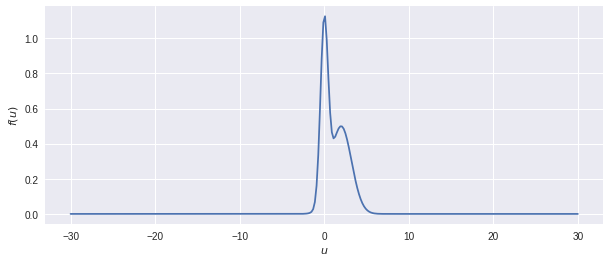

In [2]:
u = np.linspace(-30,30,300) # generate u axis values
# and plot it
plt.rcParams["figure.figsize"] = (10,4)
plt.plot(u,f(u))
plt.xlabel('$u$')
plt.ylabel('$f(u)$');

and compute its Fourier transform,  
$$ F(s) = \int_{-\infty}^{\infty} f(x)\exp(2\pi i su) \, \text{d}u. $$
Because $f(u)$ is not symmetrical around the origin the transform is complex, so we will plot the real and imaginary parts separately:

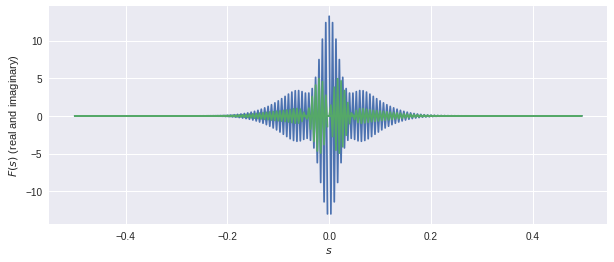

In [3]:
F =  np.fft.fft(f(u)) # do the fft of f(x) 

s = np.fft.fftfreq(F.size, 1) # generate the s axis 
plt.plot(s, (F.real), s,(F.imag))
plt.xlabel('$s$')
plt.ylabel('$F(s)$ (real and imaginary)');

Now we do the inverse transform to check we get $f(u)$ back:

In [0]:
ff =  np.fft.ifft(F) # do the inverse fft of f(u) 

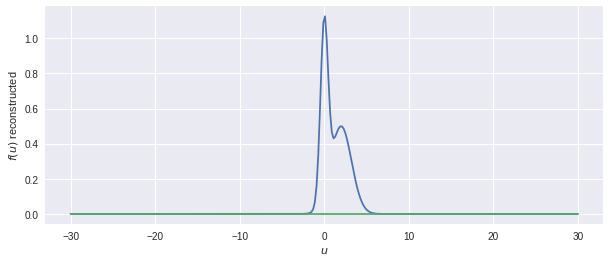

In [5]:
plt.plot(u,ff.real, u,ff.imag)
plt.xlabel('$u$')
plt.ylabel('$f(u)$ reconstructed');

You can see above that we have reconstructed the original real function $f(u)$. However there is a very small imaginary component now due to numerical rounding errors (plot it separately and you'll see it's non-zero).

If we try this with the *power* spectrum then it doesn't work.  We get back a mangled, symmeterised version of $f(u)$ because we've set all the phases to zero.  (Think Star Trek when the transporter malfunctions):

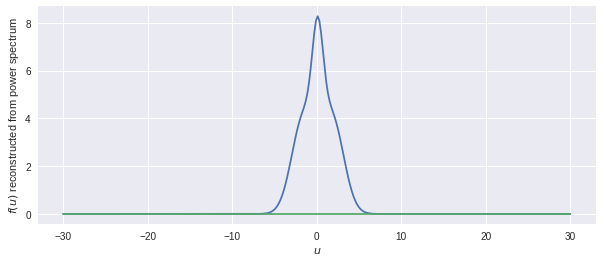

In [6]:
ff =  np.fft.fftshift(np.fft.ifft(np.abs(F)**2)) # do the fft of |F(x)|^2. The shift is necessary for this one.
plt.plot(u,ff.real, u,ff.imag)
plt.xlabel('$u$')
plt.ylabel('$f(u)$ reconstructed from power spectrum');

### 2: Convolution is your friend
Convolution is one of the most useful ideas in Fourier theory.  The convolution of $f(x)$ and $g(x)$ is defined as
$$ h(y) = \int  f(x) g(y-x) \, \text{d}x \equiv f * g,$$
and the convolution theorem states that
$${\cal F}(f * g)  = {\cal F}(f) \cdot {\cal F}(g)$$ and
$${\cal F}(f\cdot g)  = {\cal F(f)} * {\cal F}(g),$$
where $\cal F$ denotes a Fourier transform, so ${\cal F }(f) \equiv F$ in our notation.  

This comes into its own when one considers the convolution of a function $f(x)$ with Dirac delta function positioned at $a$, $\delta(x-a)$.  This convolution gives the function  $f(x)$ but moved to be centred at $a$:
$$ \delta(x-a) * f(x) = f(x-a).$$
We can show this in Python:

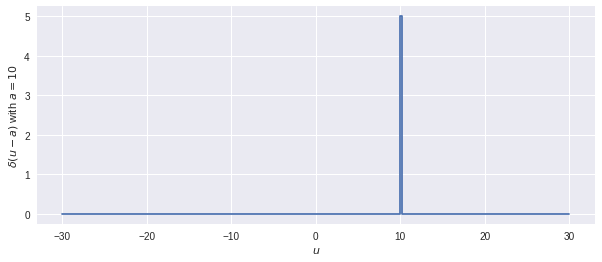

In [7]:
# generate a delta function at x=10.  In discrete maths this can be approximated by filling a single bin. 
# The value is chosen so that value*binwidth = 1.  In this case, the value is 5 .
delta = np.zeros(len(u))
delta[200] = 5
plt.step(u,delta) # plot like a bargraph
plt.xlabel('$u$')
plt.ylabel('$\delta(u-a)$ with $a=10$');

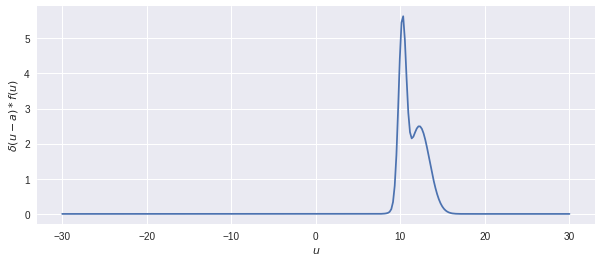

In [8]:
c = np.convolve(f(u),delta,'same')
plt.plot(u,c) 
plt.xlabel('$u$')
plt.ylabel('$\delta(u-a)* f(u)$');

Our function has been shifted to be centred on $u=10$.

The convolution theorem tells us that the Fourier transform of $f(u-a)$ is the product of the Fourier transform of $f(u)$ and the Fourier transform of $\delta(u-a)$ (which is simply $\exp(2\pi i s a)$):
$$
{\cal F}(f(u-a)) = \int \delta(u-a) \exp(2 \pi i u s) \, \text{d}u \cdot \int f(u) \exp(2 \pi i u s)  \, \text{d}u = \exp(2\pi i s a) F(s).
$$
We immediately see that the effect of shifting the position of $f$ is to introduce a phase ramp in the transform, but otherwise to leave it unchanged.  Therefore the beam pattern, which is the square modulus of the transform of the aperture function and is therefore insensitive to phase, is not affected if we move the antenna to a different location. An antenna has the same pattern no matter where it is located.

Convolution with a smooth function produced a 'blurring' effect. Every point in one function is replaced with a copy of the other, and the result summed.  Let's convolve $f(u)$ with a gaussian:

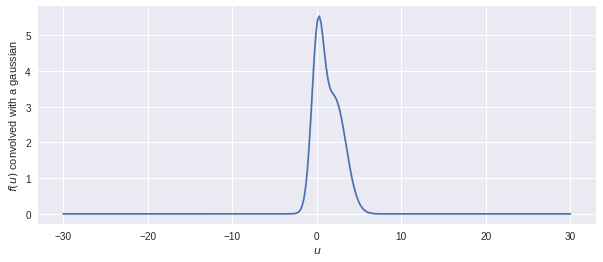

In [9]:
blurred = np.convolve(f(u),np.exp(-(u/0.8)**2),'same') # try changing the width of the gaussian (start at 0.8)...
plt.plot(u,blurred) 
plt.xlabel('$u$')
plt.ylabel('$f(u)$ convolved with a gaussian');

### Computing antenna power patterns via convolution and multiplication 

We can use these ideas to construct complex aperture functions.  Let's start with a fundamental result based on a comb of delta functions, $c(u)$, evenly spaced in $u$ with a separation $a$:
$$
c(u) = \sum_{j=-\infty}^{\infty} \delta(u-aj)
$$

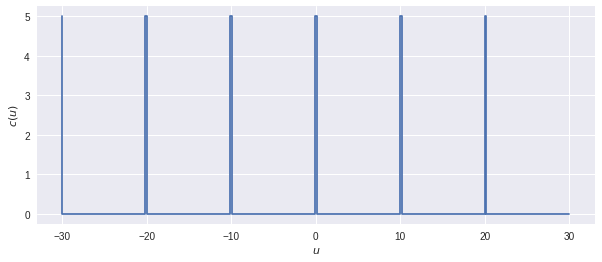

In [10]:
comb = np.zeros(len(u))
for  i in range(0,6):
    comb[i*50] = 5
plt.step(u,comb) # plot like a bargraph
plt.xlabel('$u$')
plt.ylabel('$c(u)$');

We can convolve $c(u)$ with our standard $f(u)$.  It's like a potato print:

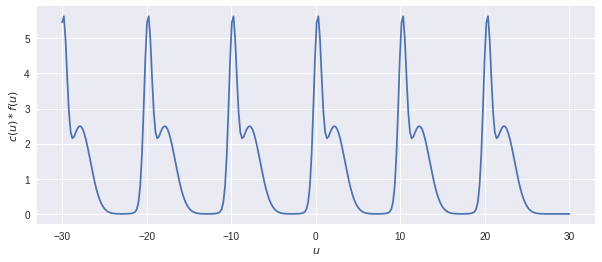

In [11]:
aperture = np.convolve(f(u),comb,'same')
plt.plot(u,aperture) 
plt.xlabel('$u$')
plt.ylabel('$c(u) * f(u)$');

If we think of this as an aperture function from an array of (slightly odd!) antennas each with an aperture function $f(u)$ then we can compute the beam pattern of the array:

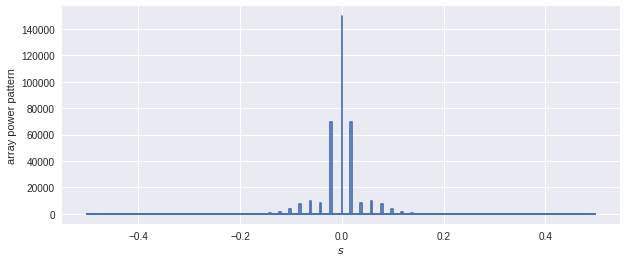

In [12]:
ppattern =  np.abs(np.fft.fft(aperture))**2
plt.step(s,ppattern)
plt.xlabel('$s$')
plt.ylabel('array power pattern');

Let's understand this. The transform of an infinite comb is another infinite comb:
$$
C(s) = {\cal F}(c(x)) = \sum_j \exp(2\pi i ajs) = \frac{1}{a}\sum_j \delta\left(s-\frac{j}{a}\right)
$$
and the transform of our array aperture function should, by the convolution theorem, be the (mod-squared of) product of this comb with the transform of the repeating element:

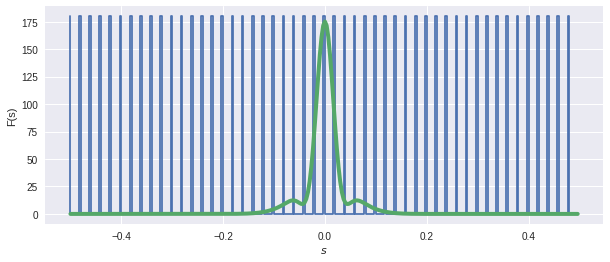

In [13]:
plt.step(np.fft.fftshift(s),0.2*np.fft.fftshift(np.abs(np.fft.fft(comb)))**2) # the power pattern of the comb
plt.plot(np.fft.fftshift(s),np.fft.fftshift(np.abs(np.fft.fft(f(u))))**2,linewidth =4) # the power pattern of one element
plt.xlabel('$s$')
plt.ylabel('F(s)');

That looks consistent: the product of the blue comb and the orange power pattern from a single element gives the power pattern of the array shown above.  The central peak is very narrow (this is an infinite array after all!) and there are grating responses that die away to the sides.  It's clear that they are attenuated because the individual elements become insensitive at larger angles from the zenith. 

### A finite array of finite elements
We chose an asymmetrical form for $f(u)$ to be as general as possible. A more likely aperture function would be symmetrical, and maybe uniform over each element.

Let's define the aperture function for a single element as $A(s)$ and make it a top hat of width 4:

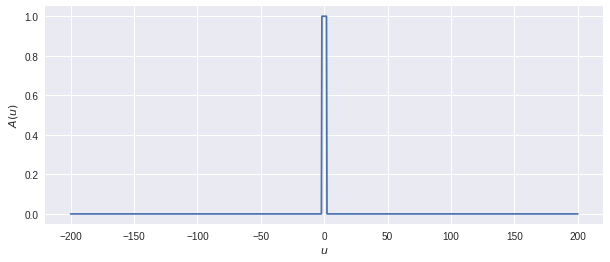

In [14]:
u = np.linspace(-200,200,1000) # generate u axis values -- an expanded scale to make the power pattern easier to see later
A =np.piecewise(u, [np.abs(u) < 2, np.abs(u) >= 2], [1, 0]) 
plt.plot(u,A)
plt.xlabel('$u$')
plt.ylabel('$A(u)$');

Lets say there are three of these, spaced 10 units apart.  We can construct this with a convolution and a multiplication.  First, make an infinite array of these elements:

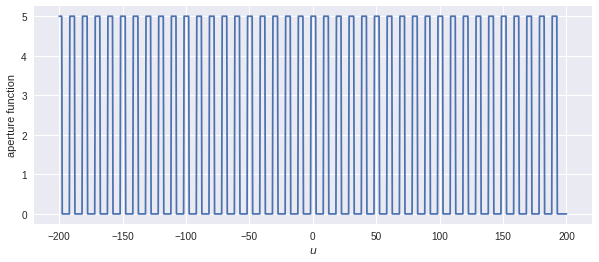

In [15]:
comb = np.zeros(len(u))
for  i in range(0,40):
    comb[i*25] = 5
A2 = np.convolve(A,comb,'same')
plt.plot(u,A2) 
plt.xlabel('$u$')
plt.ylabel('aperture function');

... then we can turn it into just three elements by multiplying the above by a broad top hat of width (say) +/- 17 units:

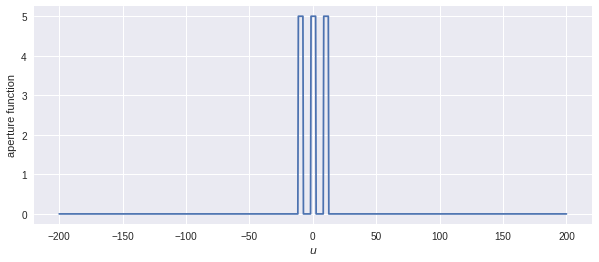

In [16]:
A3 = A2 * np.piecewise(u, [np.abs(u) < 17, np.abs(u) >= 17], [1, 0]) 
plt.plot(u,A3) 
plt.xlabel('$u$')
plt.ylabel('aperture function');

Finally we can compute the antenna pattern using a Fourier transform:

(-0.2, 0.2)

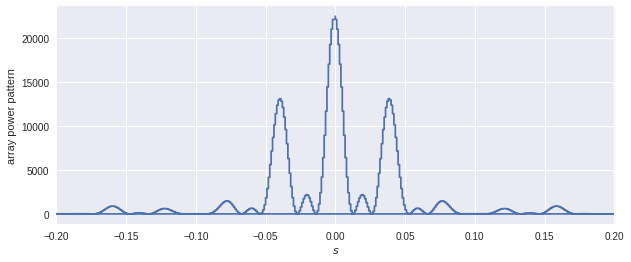

In [17]:
ppattern =  np.abs(np.fft.fft(A3))**2
s2 = np.fft.fftfreq(A3.size, 1) # generate the s axis 
plt.step(s2,ppattern)
plt.xlabel('$s$')
plt.ylabel('array power pattern')
plt.xlim(-0.2, 0.2)

This transform is quite straightforward in Python, but one can also do it analytically by considering the aperture function as being constructed out of convolutions and multiplications of simpler comb and top-hat functions and using the convolution theorem to combine their transforms. The result will be the same as the graph above.

### Moving to two dimensions

We have only considered one dimensional apertures here.  The move to two dimensions is straightforward, as the Fourier transform extends smoothly:
$$
{\cal F}(f(u,v)) = F(s,t) = \int_{-\infty}^{\infty}\int_{-\infty}^{\infty} f(u,v)\exp[2\pi i (su + tv)] \, \text{d}u\text{d}v,
$$
and again this can be applied to aperture functions when the angles involved are small.  For example, a circular aperture:

In [0]:
f = np.zeros((512,512))

In [0]:
for x in range(-256,256):
    for y in range(-256,256):
        f[x+256,y+256] = (x**2+y**2)<10**2

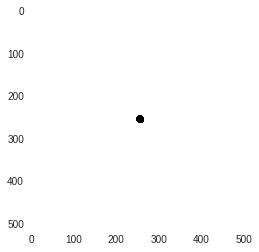

In [20]:
plt.imshow(f); # here is the aperture

In [0]:
F = np.fft.fftshift(np.fft.fft2(f))
P = np.abs(F)**2

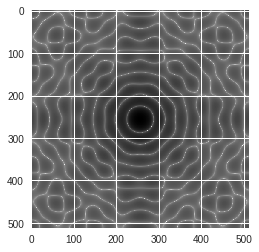

In [22]:
plt.imshow(np.log(P)); # and here is its beam pattern (or diffraction pattern if you prefer)
# taking the log to make it easier to see the sidelobes.